In [1]:
import sys
sys.path.append('tcnnqc_RL')
from util import *
# import util
import gym
import gym_minigrid
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt 
import torchquantum as tq
from torch.distributions import Categorical

torch.manual_seed(46)
np.random.seed(46)

device = torch.device("cuda:0")
# device = torch.device("cpu")

/home/chenyu/anaconda3/envs/tq/lib/python3.9/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [2]:

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.softmax(x + 1e-8, dim=-1) 

# Function to select an action based on the policy probabilities

def select_action(policy, state):
    state = state.to(device)  # Move state to GPU if necessary
    action_probs = policy(state)
    action_dist = torch.distributions.Categorical(action_probs)
    action = action_dist.sample()
    return action.item(), action_dist.log_prob(action), action_probs


# Function to train the policy network using policy gradients with entropy regularization
def train_policy(optimizer, policy, rewards, log_probs, action_probs, gamma=0.99, beta=0.05):
    returns = []
    discounted_reward = 0
    for reward in rewards[::-1]:
        discounted_reward = reward + gamma * discounted_reward
        returns.insert(0, discounted_reward)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-6)
    policy_loss = []
    entropy_loss = 0
    for log_prob, prob, R in zip(log_probs, action_probs, returns):
        policy_loss.append(-log_prob * R)
        entropy_loss += -torch.sum(prob * torch.log(prob + 1e-8))  # Compute entropy loss
        
    optimizer.zero_grad()
    policy_loss = torch.stack(policy_loss).sum()
    loss = policy_loss - beta * entropy_loss  # Combine policy loss and entropy loss
    loss.backward()
    nn.utils.clip_grad_norm_(policy.parameters(), 10)
    optimizer.step()

# Main training loop
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#env = gym.make('MiniGrid-Empty-Random-5x5-v0')

env = gym.make('MiniGrid-Empty-5x5-v0')
input_size = 1 
for i in range(len(env.observation_space['image'].shape)):
    input_size *= env.observation_space['image'].shape[i]
    
# input_size = env.observation_space['image'].shape[0]


output_size = 3 #env.action_space.n
hidden_size = 32
policy = PolicyNetwork(input_size, hidden_size, output_size).to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-4)
num_episodes = 4000
max_steps = 100

print("input_size", input_size)
print("hidden_size", hidden_size)
print("output_size", output_size)



input_size 147
hidden_size 32
output_size 3


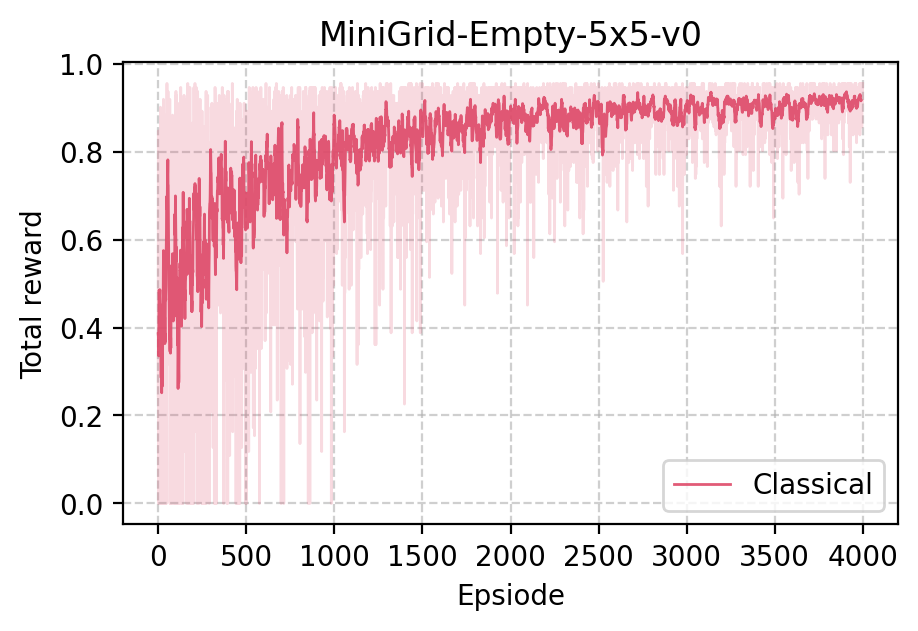

In [3]:

# Define a function to calculate the moving average
def moving_average(data, window_size=10):
    moving_avg = []
    for i in range(len(data) - window_size + 1):
        avg = sum(data[i:i+window_size]) / window_size
        moving_avg.append(avg)
    return moving_avg

# Calculate the moving average of the total rewards
window_size = 10
# total_reward_list_qt_avg = moving_average(total_reward_list_qt, window_size)
total_reward_list_avg    = moving_average(total_reward_list, window_size)



plt.figure(figsize=(5,3), dpi = 200)
plt.plot(total_reward_list ,color=plt.cm.magma(0.6), marker = "", markersize=2, lw = 1, alpha = 0.2)#, label = "Classical")
plt.plot(total_reward_list_avg ,color=plt.cm.magma(0.6), marker = "", markersize=2, lw = 1, alpha = 0.9, label = "Classical")


plt.title("MiniGrid-Empty-5x5-v0")
plt.xlabel("Epsiode")
plt.ylabel("Total reward")
plt.grid(True, linestyle='--', alpha = 0.6)
plt.legend()
plt.show()


In [4]:
n_qubit, nw_list_normal = required_qubits_estimation(policy)
network_config          = network_config_extract(policy)

## Make sure layers and activation functions are properly read
for i in network_config:
    print(i)

# of NN parameters:  4835
Required qubit number:  13
{'type': 'PolicyNetwork', 'name': '', 'params': {}}
{'type': 'Linear', 'name': 'fc1', 'params': {}}
{'type': 'ReLU', 'name': 'relu', 'params': {}}
{'type': 'Linear', 'name': 'fc2', 'params': {}}
{'type': 'Softmax', 'name': 'softmax', 'params': {}}


In [9]:

### Training setting ########################

step       = 1e-4   # Learning rate
q_depth    = 13     # Depth of the quantum circuit (number of variational layers)


# Instantiate the model, move it to GPU, and set up loss function and optimizer
policy_qt = QuantumTrain(
                        policy,
                        n_qubit,
                        nw_list_normal,
                        q_depth,
                        device,
                        network_config,
                        gamma = 0.1,
                        beta  = 1,
                        alpha = 1,
                        mm_arch = [10, 64, 10],
                        )().to(device)

optimizer = optim.Adam([
    {'params': policy_qt.QuantumNN.parameters()},
    {'params': policy_qt.MappingNetwork.parameters()}
], lr=step)



In [10]:

num_trainable_params_MM = sum(p.numel() for p in policy_qt.MappingNetwork.parameters() if p.requires_grad)
num_trainable_params_QNN = sum(p.numel() for p in policy_qt.QuantumNN.parameters() if p.requires_grad)
num_trainable_params = sum(p.numel() for p in policy_qt.parameters() if p.requires_grad)

print("# of trainable parameter in Mapping model: ", num_trainable_params_MM)
print("# of trainable parameter in QNN model: ", num_trainable_params_QNN)
print("# of trainable parameter in full model: ", num_trainable_params)


# of trainable parameter in Mapping model:  1515
# of trainable parameter in QNN model:  1014
# of trainable parameter in full model:  2529


In [ ]:


env = gym.make('MiniGrid-Empty-5x5-v0')


num_episodes = 4000
max_steps = 100

total_reward_list_qt = [] 

for episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor(state[0]['image']).flatten().float().to(device)  # Convert to PyTorch tensor and move to GPU

    rewards = []
    log_probs = []
    action_probs_list = []
    # print("========= Episode ", episode + 1, " =========")
    for step in range(max_steps):
        action, log_prob, action_probs = select_action(policy_qt, state)
        # print("Episode ", episode + 1, " , step ", step, ", action:", action)
        next_state, reward, done, _, __ = env.step(action)
        # print("reward:", reward)
        next_state = torch.tensor(next_state['image']).flatten().float().to(device)  # Convert to PyTorch tensor and move to GPU

        rewards.append(reward)
        log_probs.append(log_prob)
        action_probs_list.append(action_probs)
        if done:
            # print("DONE!!")
            # print("rewards:", rewards)
            # print("len(rewards)", len(rewards))
            break
        
        state = next_state
    
    if len(rewards) != 1:   # avoid start from end 
        train_policy(optimizer, policy_qt, rewards, log_probs, action_probs_list)
        total_reward = sum(rewards)
        print(f'Episode {episode + 1}, Total Reward: {total_reward}')
        total_reward_list_qt.append(total_reward)
    
env.close()

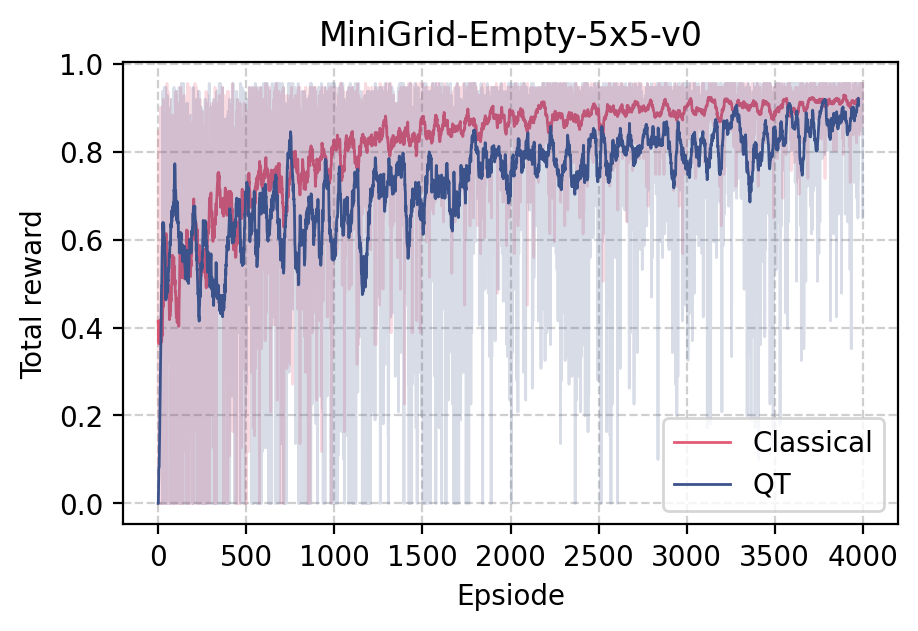

In [25]:

# Define a function to calculate the moving average
def moving_average(data, window_size=10):
    moving_avg = []
    for i in range(len(data) - window_size + 1):
        avg = sum(data[i:i+window_size]) / window_size
        moving_avg.append(avg)
    return moving_avg

# Calculate the moving average of the total rewards
window_size = 25
total_reward_list_qt_avg = moving_average(total_reward_list_qt, window_size)
total_reward_list_avg    = moving_average(total_reward_list, window_size)



plt.figure(figsize=(5,3), dpi = 200)
plt.plot(total_reward_list ,color=plt.cm.magma(0.6), marker = "", markersize=2, lw = 1, alpha = 0.2)#, label = "Classical")
plt.plot(total_reward_list_avg ,color=plt.cm.magma(0.6), marker = "", markersize=2, lw = 1, alpha = 0.9, label = "Classical")


plt.plot(total_reward_list_qt ,color=plt.cm.viridis(0.25), marker = "", markersize=2, lw = 1, alpha = 0.2)#, label ="QT")
plt.plot(total_reward_list_qt_avg ,color=plt.cm.viridis(0.25), marker = "", markersize=2, lw = 1, alpha = 1, label ="QT")


plt.title("MiniGrid-Empty-5x5-v0")
plt.xlabel("Epsiode")
plt.ylabel("Total reward")
plt.grid(True, linestyle='--', alpha = 0.6)
plt.legend()
# plt.xlim(len(fail_case_percentage_list) - 200, len(fail_case_percentage_list))
plt.show()

